# Lesson 8 - Time Series Simulation 
Version: Jun-2019

## Author - Robert Lisy

## Instructions

Using the California dairy production dataset, perform time series analysis on the data for one of Cottage Cheese Production, Milk Production, or Ice Cream Production (your choice) to answer the following questions:

1. Is this time series stationary?
2. Is there a significant seasonal component?
3. For the residual from the STL decomposition of the time series, what is the order of the ARMA(p,q) process that best fits?


Use the auto_arima function from the pmdarima package to find a best model fit, excluding the last 12 months of observations from the training data, and setting d=1 and D=1 and limit p, q, P and Q to 3 with starting values of 1. 
- Which model coefficients are statistically significant?
- Then forecast production for the last 12 months of the data and report both the numeric values and plot the prediction vs. the actual production values with the calculated prediction intervals.

Are the predictions close to the actual observations?
Are the residuals approximately Normally distributed?
What is the RMSE? Is this value small relative to the forecasted values?
Are the confidence intervals reasonably small compared to the forecast means?
How do the confidence intervals behave as time moves to the future?


### Note
Please clearly outline the results with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [1]:
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/CADairyProduction.csv"

In [56]:
# Load necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.graphics.tsaplots as splt
import statsmodels.api as statsmodels
import statsmodels.formula.api as sm
import statsmodels.tsa.seasonal as sts
import sklearn.metrics as m
import math
from pmdarima import auto_arima

# used to check if the time series is stationary.
from statsmodels.tsa.stattools import adfuller
matplotlib.rcParams['figure.figsize'] = [15, 5]

df = pd.read_csv(fileName)

# ACF / PACF plot
def plot_acf_pacf(x, lags = 40):
    x = x[x.notna()] # remove NAs
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    fig = splt.plot_acf(x, lags = lags, ax = axes[0])
    fig = splt.plot_pacf(x, lags = lags, ax = axes[1]);
    return None

# Residuals plot
def plot_ts_resid(x):
    x = x[x.notna()] # remove NAs
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    fig = sns.lineplot(x.index, x, ax = axes[0])
    fig = sns.distplot(x, ax = axes[1]);
    return None

# easy to change...
analysis_col = 'Icecream.Prod'

In [3]:
# add a combined column for year and month...
df['yyyy_mm'] = df['Year'].astype(str) + '_' + df['Month.Count'].astype(str)
df.head()

,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed,yyyy_mm
0,1995,Jan,4.370,51.595,2.112,0.9803,1,1,1,1995_1
1,1995,Feb,3.695,56.086,1.932,0.8924,2,4,8,1995_2
2,1995,Mar,4.538,68.453,2.162,0.8924,3,9,27,1995_3
3,1995,Apr,4.280,65.722,2.130,0.8967,4,16,64,1995_4
4,1995,May,4.470,73.730,2.227,0.8967,5,25,125,1995_5


In [4]:
# find the range of the data set...
print(f"Min year: {df['Year'].min()}")
print(f"Max year: {df['Year'].max()}")
df_2013 = df[df['Year'] == 2013]
df_2013.head(12)

Min year: 1995
Max year: 2013


,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed,yyyy_mm
216,2013,Jan,2.282,62.612,3.462,1.7744,217,47089,10218313,2013_217
217,2013,Feb,1.941,66.274,3.231,1.6224,218,47524,10360232,2013_218
218,2013,Mar,2.150,75.770,3.676,1.6968,219,47961,10503459,2013_219
219,2013,Apr,2.217,76.396,3.622,1.7444,220,48400,10648000,2013_220
220,2013,May,2.341,80.899,3.720,1.8552,221,48841,10793861,2013_221
221,2013,Jun,2.694,92.091,3.489,1.8314,222,49284,10941048,2013_222
222,2013,Jul,2.433,84.026,3.373,1.6923,223,49729,11089567,2013_223
223,2013,Aug,2.169,78.382,3.400,1.6273,224,50176,11239424,2013_224
224,2013,Sep,2.193,74.871,3.197,1.5519,225,50625,11390625,2013_225
225,2013,Oct,2.284,70.011,3.338,1.5566,226,51076,11543176,2013_226


In [5]:
# make a time series object
s = '1-1-1995'
e = '12-31-2013'
ts = df[analysis_col]
ts.index = pd.date_range(start = s , end = e, freq = 'M')
ts.head(5)

1995-01-31    51.595
1995-02-28    56.086
1995-03-31    68.453
1995-04-30    65.722
1995-05-31    73.730
Freq: M, Name: Icecream.Prod, dtype: float64

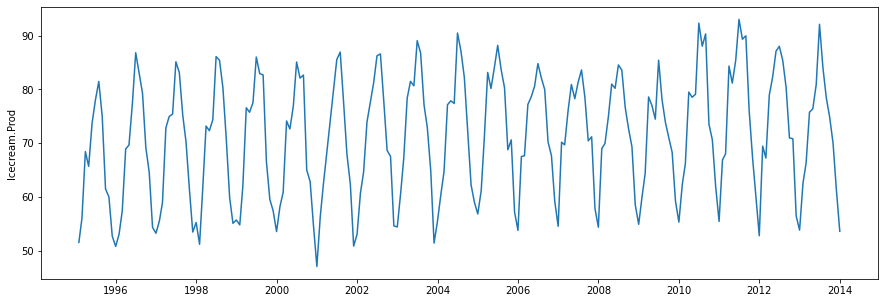

In [6]:
# first lets plot the series...
sns.lineplot(x = ts.index, y = ts);

In [7]:
# Try and decompose the time series..
def decomp_ts(ts, freq = 'M', model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model) #, freq = freq)
    return(pd.DataFrame({'ts': ts, 'trend': res.trend, 'seasonal': res.seasonal, 'resid': res.resid}, 
                        index = ts.index))

decomp = decomp_ts(ts)
decomp.head()

,ts,trend,seasonal,resid
1995-01-31,51.595,NaN,-10.272597,NaN
1995-02-28,56.086,NaN,-6.441930,NaN
1995-03-31,68.453,NaN,4.732371,NaN
1995-04-30,65.722,NaN,5.813755,NaN
1995-05-31,73.730,NaN,7.914674,NaN


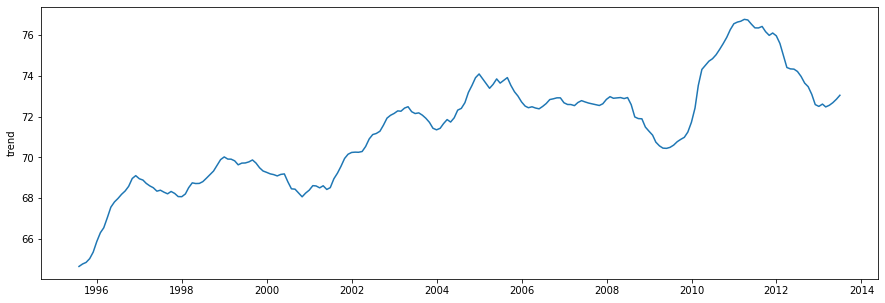

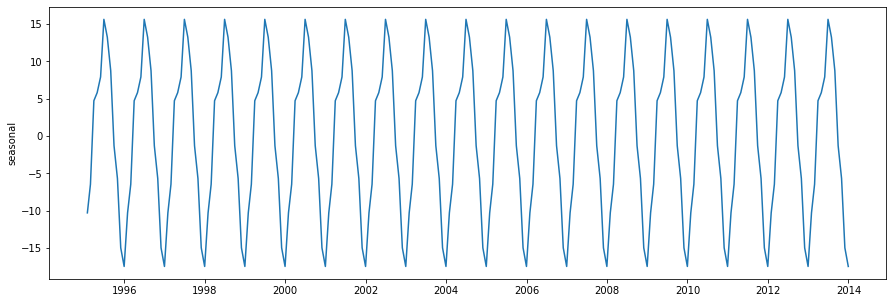

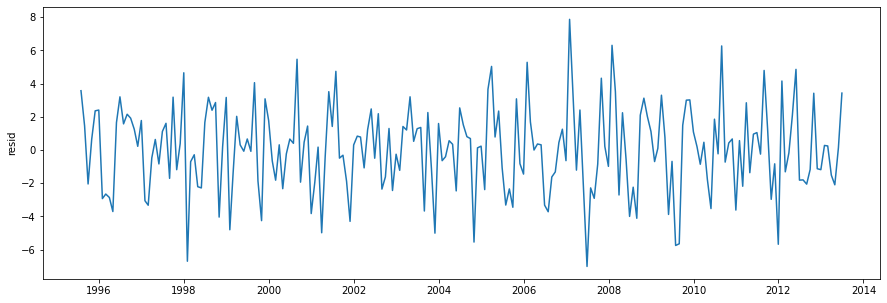

In [8]:
# Plot the components of the decomposition
plot_cols = ['trend', 'seasonal', 'resid']

for c in plot_cols:
    sns.lineplot(x = decomp.index, y = decomp[c])
    plt.show();

In [9]:
# is the data stationary?

# ye ole Dicky Fuller test
def DF_Test(ts):
    ts = ts[ts.notna()]
    stationary = adfuller(ts)
    print('D-F statistic = ' + str(stationary[0]))
    print('p-value = ' + str(stationary[1]))
    print('number of lags used = ' + str(stationary[2]))
    print('Critical value at 5% confidence = ' + str(stationary[4]['5%']))
    print('Critical value at 10% confidence = ' + str(stationary[4]['10%']))
    return None


DF_Test(ts)

D-F statistic = -2.509153936192523
p-value = 0.11326293037432805
number of lags used = 14
Critical value at 5% confidence = -2.875206950587861
Critical value at 10% confidence = -2.5740544497344002


# Stationary

This is a hard one... the data is probably not stationary, since Dicky Fuller rejects it at 95% confidence. However it's marginal since it accepts it at 90%. I'd vote a NO though, given the high seasonal component.

## Seasonality

Yes, there appears to be yearly seasonality in this data... people buy more ice cream in the summer! Check that seasonal graph!

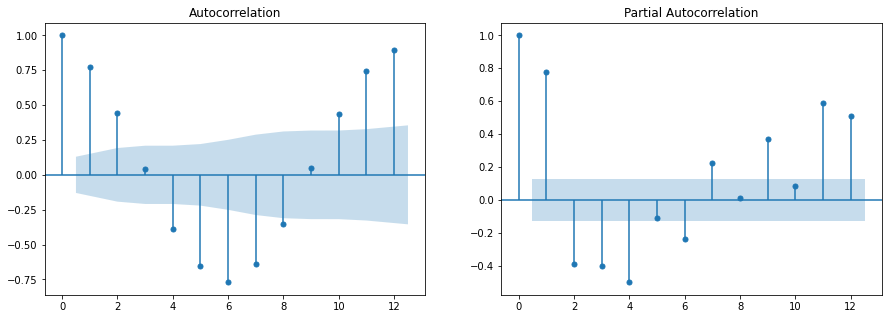

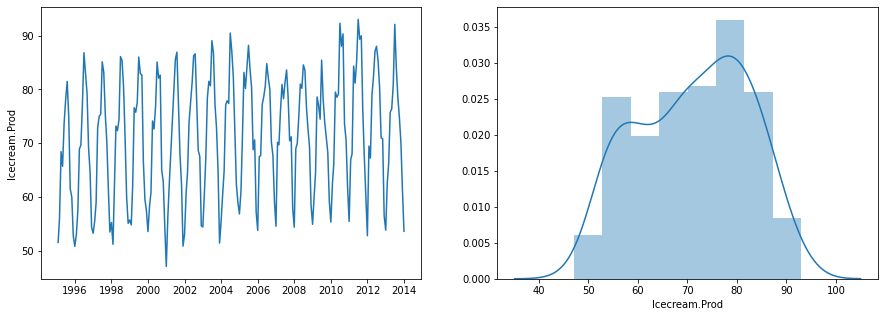

In [10]:
# Now we will use the ACF, PACF, and residuals to deterimine the ARIMA (p,d,q) order
plot_acf_pacf(ts, lags = 12)
plot_ts_resid(ts)

## Find a best model fit

excluding the last 12 months of observations from the training data, and setting d=1 and D=1 and limit p, q, P and Q to 3 with starting values of 1. Which model coefficients are statistically significant?
Then forecast production for the last 12 months of the data and report both the numeric values and plot the prediction vs. the actual production values with the calculated prediction intervals.

Are the predictions close to the actual observations?
Are the residuals approximately Normally distributed?
What is the RMSE? Is this value small relative to the forecasted values?
Are the confidence intervals reasonably small compared to the forecast means?
How do the confidence intervals behave as time moves to the future?

In [24]:
# make a time series object without the last 12 months...
s = '1-1-1995'
e = '12-31-2012'
rws = df.shape[0] - 12

history_ts = df[0:rws][analysis_col]
history_ts.index = pd.date_range(start = s , end = e, freq = 'M')
history_ts.tail(12)

2012-01-31    69.463
2012-02-29    67.259
2012-03-31    78.959
2012-04-30    82.236
2012-05-31    87.093
2012-06-30    88.012
2012-07-31    85.400
2012-08-31    80.328
2012-09-30    71.003
2012-10-31    70.840
2012-11-30    56.506
2012-12-31    53.870
Freq: M, Name: Icecream.Prod, dtype: float64

In [25]:
best_fit = auto_arima(history_ts, 
                      max_p = 3, max_d = 1, max_q = 3, 
                      m = 12, max_P = 1, max_D = 1, max_Q = 1, 
                      information_criterion = 'bic', 
                      trace = True, error_action = 'ignore', suppress_warnings = True)

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=1225.358, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=1665.348, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=1356.290, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=2465.816, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : BIC=1329.877, Time=0.63 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : BIC=1209.930, Time=0.67 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : BIC=1349.056, Time=0.33 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : BIC=inf, Time=0.58 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : BIC=inf, Time=0.68 sec
 ARIMA(3,0,2)(1,0,0)[12] intercept   : BIC=inf, Time=0.87 sec
 ARIMA(2,0,3)(1,0,0)[12] intercept   : BIC=inf, Time=0.72 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=inf, Time=0.42 sec
 ARIMA(1,0,3)(1,0,0)[12] intercept   : BIC=inf, Time=0.62 sec
 ARIMA(3,0,1)(1,0,0)[12] intercept   : BIC=inf, Time=0

## The best model is the ARIMA(2,0,2)

In [36]:
best_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  216
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 12)   Log Likelihood                -586.151
Date:                             Fri, 28 Aug 2020   AIC                           1186.303
Time:                                     09:57:27   BIC                           1209.930
Sample:                                          0   HQIC                          1195.848
                                             - 216                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     27.4495      5.412      5.072      0.000      16.843      38.056
ar.L1         -1.6499      0.072    -23.004      0.000      -1.790      -1.509
ar.L2         -0.6530      0.075     -8.671      0.000      -0.801      -0.505
ma.L1          1.9661      0.027     72.375      0.000       1.913       2.019
ma.L2          0.9684      0.027     36.120      0.000       0.916       1.021
ar.S.L12       0.8791      0.024     35.885      0.000       0.831       0.927
sigma2        11.3417      0.947     11.978      0.000       9.486      13.198
===================================================================================
Ljung-Box (Q):                      130.42   Jarque-Bera (JB):                21.31
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                             0.22
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Which coefficients are significant?

Looks like all of them:
- ar.L1
- ar.L2
- ma.L1
- ma.L2
- ar.S.L12
- sigma2

have a p-value which is VERY low, so they're significant.

In [32]:
future_forecast, conf_int = best_fit.predict(n_periods=12, return_conf_int=True)
future_index = pd.date_range(start = '1-1-2013', end = '12-31-2013', freq = 'M')

future_forecast = pd.DataFrame(future_forecast, index = future_index, columns=['fcst'])

# append the confidence interval
conf_df = pd.DataFrame(conf_int, index = future_index, columns=['5%', '95%'])
future_forecast = pd.concat([future_forecast, conf_df], axis=1, sort=False)

future_forecast.head()

,fcst,5%,95%
2013-01-31,68.384190,61.783317,74.985064
2013-02-28,68.017260,61.094397,74.940123
2013-03-31,77.420249,70.364816,84.475683
2013-04-30,80.731888,73.621368,87.842409
2013-05-31,84.867446,77.734229,92.000662


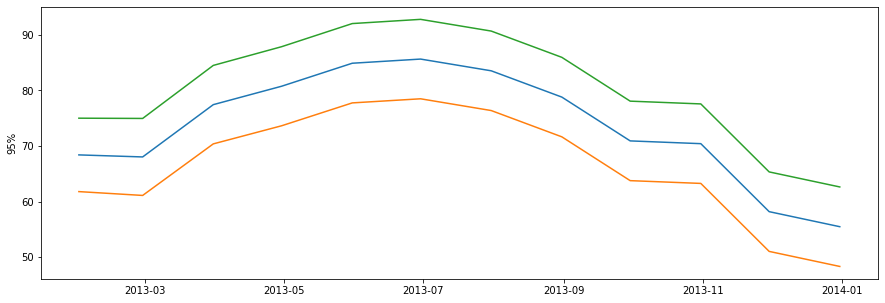

In [33]:
# plot the future forecast and the existing data
plot_cols = ['fcst', '5%', '95%']

for c in plot_cols:
    sns.lineplot(x = future_forecast.index, y = future_forecast[c])
    
plt.show()

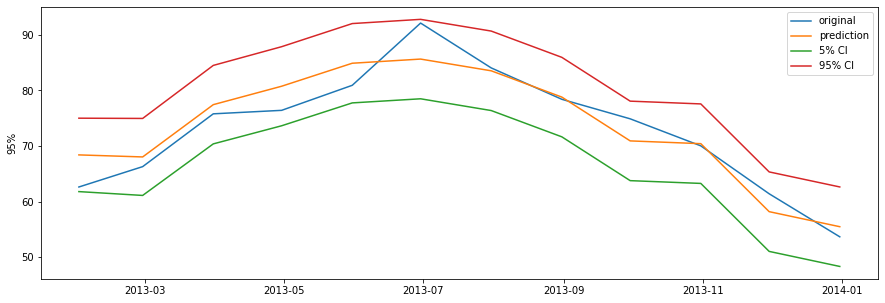

In [45]:
# Combine actuals and forecast
combo_df = pd.concat([ts, future_forecast], axis = 1)
plot_df = combo_df.tail(12)

# plot them together on the same graph
sns.lineplot(x = plot_df.index, y = plot_df[analysis_col])
sns.lineplot(x = plot_df.index, y = plot_df['fcst'])
sns.lineplot(x = plot_df.index, y = plot_df['5%'])
sns.lineplot(x = plot_df.index, y = plot_df['95%'])
plt.legend(['original', 'prediction', '5% CI', '95% CI']);
plt.show()

## Are the predictions close to the actual observations?
Yeah, they look really good actually.

## Are the residuals approximately Normally distributed?

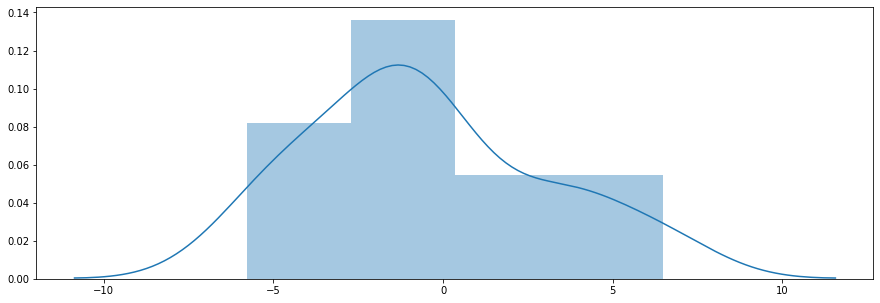

In [49]:
# let's calculate and plot the residuals
residuals = plot_df[analysis_col] - plot_df['fcst']
sns.distplot(residuals);

The residuals are few (there's only 12) but they look to be about normally distributed. There may be a slight left skew...

## What is the RMSE? Is this value small relative to the forecasted values?

In [60]:
mse = m.mean_squared_error(plot_df[analysis_col], plot_df['fcst'])
rmse = np.sqrt(mse)
print(f"RMSE is {rmse}, which is about 5% of the forecasted values")

RMSE is 3.4827359750264226, which is about 5% of the forecasted values


## Are the confidence intervals reasonably small compared to the forecast means?

They are, they're about +/- 10%. I guess in some sense this answer depends on your risk tolerance for being wrong...

## How do the confidence intervals behave as time moves to the future?

This is strange, they don't widen out into the future much. This could be because the trend is so well established, and the variance in the data is very predictable.